[*********************100%***********************]  20 of 20 completed


Factor Data (factors_df) head:
                   Momentum  MeanReversion  Volatility  VolumeSpike  \
Date       Ticker                                                     
2022-03-02 AAPL   -0.044887       0.537739    0.015736     0.012919   
           ADBE   -0.120900       0.308119    0.029190     0.053701   
           AMZN    0.005682       0.306666    0.040696     0.060466   
           BAC    -0.080528       1.581063    0.020313     0.067635   
           BRK-B   0.030832      -1.694948    0.013221     0.061343   

                         RSI  ReturnSkewness  
Date       Ticker                             
2022-03-02 AAPL    36.050483        1.569191  
           ADBE    32.809838        0.371786  
           AMZN    38.132232        1.589482  
           BAC     22.382674        0.242453  
           BRK-B   51.399386        0.533410  

Forward Returns (forward_returns) head:
Date        Ticker
2022-01-03  AAPL     -0.012692
            ADBE     -0.018374
            AMZN    

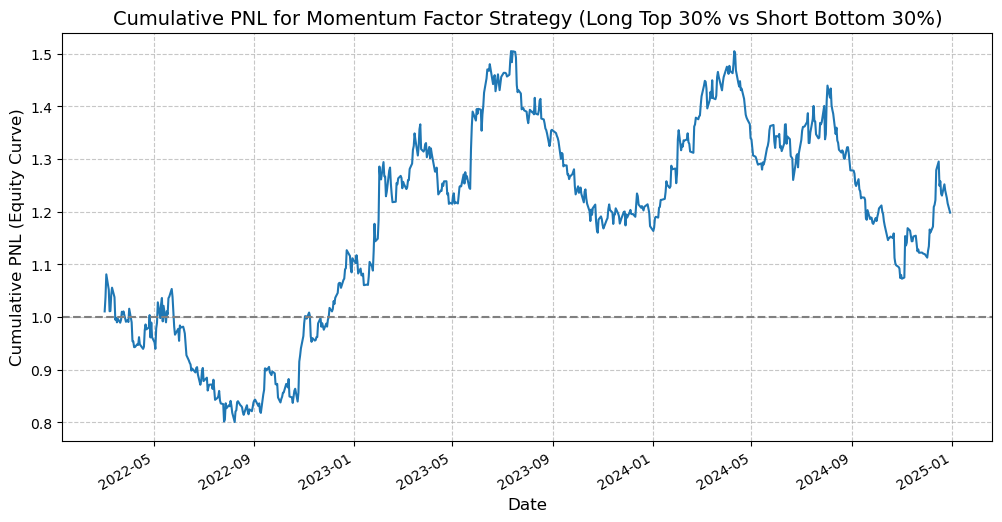


--- Processing Factor: MeanReversion ---
Factor MeanReversion - Long signals count: 4272
Factor MeanReversion - Short signals count: 3560
Factor MeanReversion - Mean Daily PNL: -0.000844, Std Dev Daily PNL: 0.014165
Factor MeanReversion - Calculated Sharpe Ratio: -0.9460


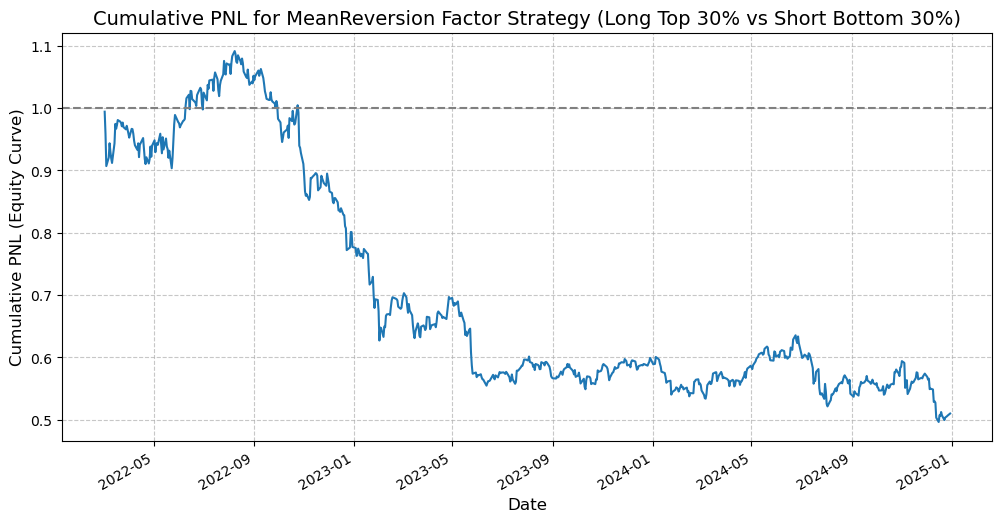


--- Processing Factor: Volatility ---
Factor Volatility - Long signals count: 4272
Factor Volatility - Short signals count: 3560
Factor Volatility - Mean Daily PNL: 0.001080, Std Dev Daily PNL: 0.017366
Factor Volatility - Calculated Sharpe Ratio: 0.9869


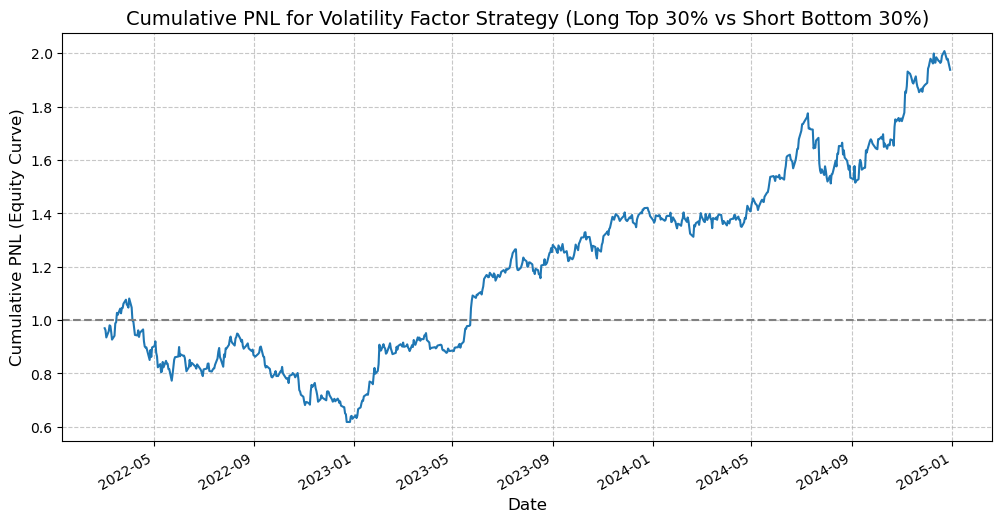


--- Processing Factor: VolumeSpike ---
Factor VolumeSpike - Long signals count: 4272
Factor VolumeSpike - Short signals count: 3560
Factor VolumeSpike - Mean Daily PNL: -0.000030, Std Dev Daily PNL: 0.012127
Factor VolumeSpike - Calculated Sharpe Ratio: -0.0390


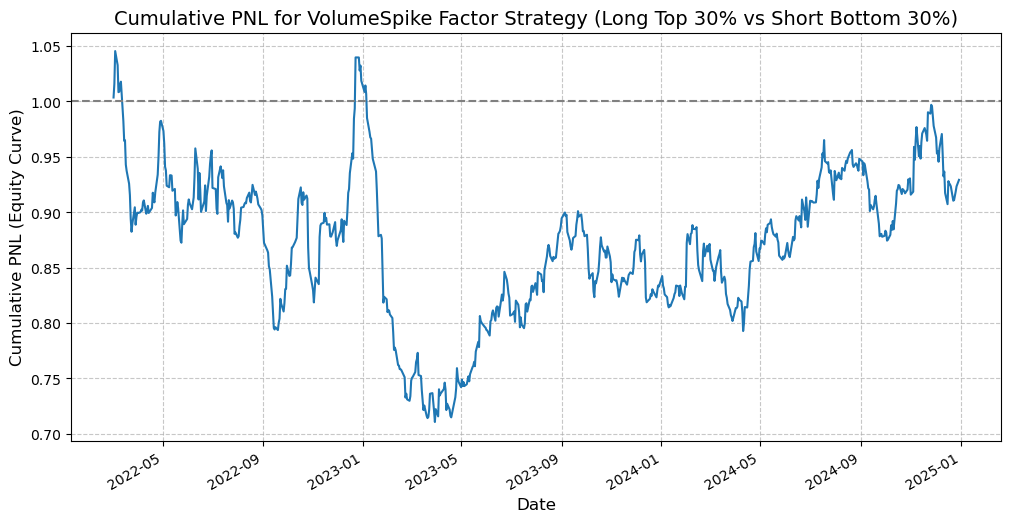


--- Processing Factor: RSI ---
Factor RSI - Long signals count: 4272
Factor RSI - Short signals count: 3560
Factor RSI - Mean Daily PNL: 0.000944, Std Dev Daily PNL: 0.014534
Factor RSI - Calculated Sharpe Ratio: 1.0311


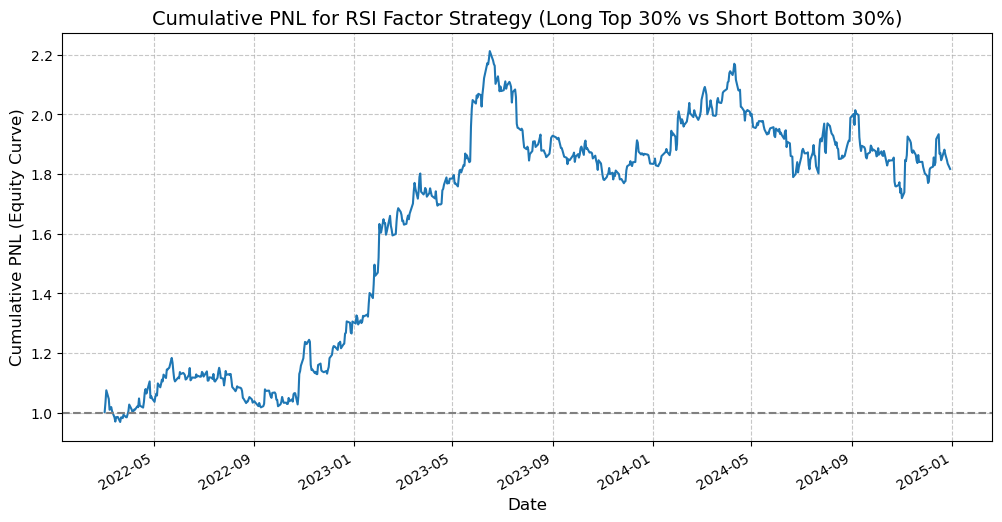


--- Processing Factor: ReturnSkewness ---
Factor ReturnSkewness - Long signals count: 4272
Factor ReturnSkewness - Short signals count: 3560
Factor ReturnSkewness - Mean Daily PNL: 0.000181, Std Dev Daily PNL: 0.010371
Factor ReturnSkewness - Calculated Sharpe Ratio: 0.2778


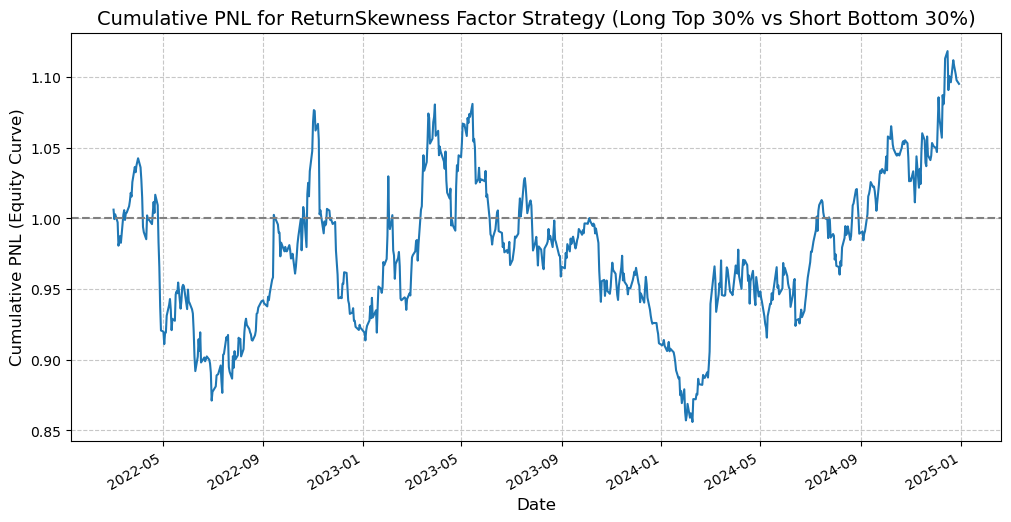


Factor Correlation Matrix:
                Momentum  MeanReversion  Volatility  VolumeSpike       RSI  \
Momentum        1.000000      -0.648133    0.031561    -0.089769  0.702358   
MeanReversion  -0.648133       1.000000    0.029939     0.074615 -0.855555   
Volatility      0.031561       0.029939    1.000000     0.047314 -0.039520   
VolumeSpike    -0.089769       0.074615    0.047314     1.000000 -0.088835   
RSI             0.702358      -0.855555   -0.039520    -0.088835  1.000000   
ReturnSkewness  0.211804      -0.113844    0.088900    -0.025846  0.108308   

                ReturnSkewness  
Momentum              0.211804  
MeanReversion        -0.113844  
Volatility            0.088900  
VolumeSpike          -0.025846  
RSI                   0.108308  
ReturnSkewness        1.000000  


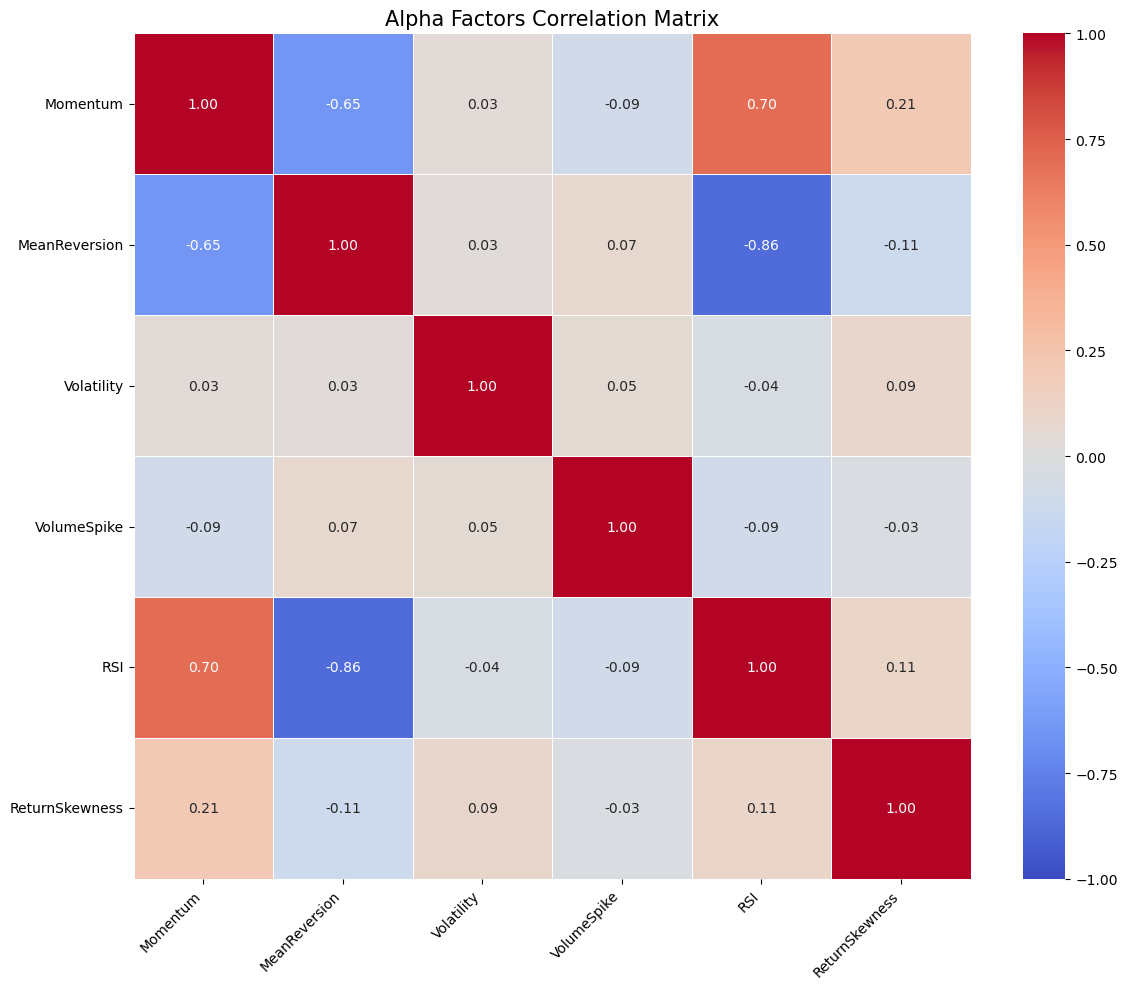


Sharpe ratios saved to: alpha_factor_analysis_results_ipynb/sharpe_ratios.csv
Stacked alpha factors data saved to: alpha_factor_analysis_results_ipynb/alpha_factors_stacked.csv
PNL series (if any) saved in directory: alpha_factor_analysis_results_ipynb

All analysis and plotting complete. Plots should be displayed above.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Parameters
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'BRK-B', 'JPM', 'JNJ',
          'V', 'PG', 'XOM', 'UNH', 'HD', 'MA', 'BAC', 'PFE', 'ADBE', 'KO']
start_date = '2022-01-01'
end_date = '2025-01-01' # Data downloaded up to 2024-12-31

# Download data
stock_data = yf.download(stocks, start=start_date, end=end_date, auto_adjust=False)
prices = stock_data['Adj Close']
volumes = stock_data['Volume']

if prices.empty or volumes.empty:
    print("Data download failed. Please check stock tickers, date range, or network connection.")
    exit()

# 1. Alpha Factor Definitions
def momentum(prices_df, window=20):
    return prices_df.pct_change(window, fill_method=None)

def mean_reversion(prices_df, window=20):
    return -(prices_df - prices_df.rolling(window).mean()) / prices_df.rolling(window).std()

def volatility(prices_df, window=20):
    return prices_df.pct_change(fill_method=None).rolling(window).std()

def volume_spike(volumes_df, window=20):
    return volumes_df.pct_change(fill_method=None).rolling(window).mean()

def rsi(prices_df, window=14):
    delta = prices_df.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    rs[loss == 0] = np.inf 
    rsi_values = 100 - (100 / (1 + rs))
    rsi_values[gain == 0] = 0 
    rsi_values[(gain == 0) & (loss == 0)] = 50
    return rsi_values

def return_skewness(prices_df, window=60): # NEW FACTOR
    """
    Rolling Skewness of Daily Returns.
    A longer window (e.g., 60, 120 days) is often used for stability.
    min_periods can be set to get values earlier.
    """
    daily_returns = prices_df.pct_change(fill_method=None)
    # Using a min_periods, e.g., 2/3 of the window, to get earlier values
    rolling_skew = daily_returns.rolling(window, min_periods=int(window*0.67)).skew()
    return rolling_skew

# Generate factor data
factors_df = pd.DataFrame()
factors_df['Momentum'] = momentum(prices).stack()
factors_df['MeanReversion'] = mean_reversion(prices).stack()
factors_df['Volatility'] = volatility(prices).stack()
factors_df['VolumeSpike'] = volume_spike(volumes).stack()
factors_df['RSI'] = rsi(prices).stack()
factors_df['ReturnSkewness'] = return_skewness(prices, window=60).stack() # Added new factor

factors_df.dropna(inplace=True)

print("Factor Data (factors_df) head:")
print(factors_df.head())

forward_returns = prices.pct_change(fill_method=None).shift(-1).stack()
forward_returns.name = 'ForwardReturn'

print("\nForward Returns (forward_returns) head:")
print(forward_returns.head())

sharpe_ratios = {}
factor_pnl_series_dict = {} 

if factors_df.empty:
    print("Factor data is empty. Cannot calculate Sharpe ratios or plot cumulative returns.")
else:
    for factor_name in factors_df.columns:
        print(f"\n--- Processing Factor: {factor_name} ---")
        factor_series = factors_df[factor_name]

        common_index = factor_series.index.intersection(forward_returns.index)
        
        if common_index.empty:
            print(f"No common index for factor {factor_name} and forward returns. Skipping.")
            sharpe_ratios[factor_name] = np.nan
            factor_pnl_series_dict[factor_name] = pd.Series(dtype=float)
            continue

        factor_aligned = factor_series.loc[common_index]
        returns_aligned = forward_returns.loc[common_index]

        if factor_aligned.empty or returns_aligned.empty:
            print(f"Aligned factor or returns data is empty for {factor_name}. Skipping.")
            sharpe_ratios[factor_name] = np.nan
            factor_pnl_series_dict[factor_name] = pd.Series(dtype=float)
            continue
        
        # ascending=True means smaller original factor values get lower ranks (closer to 0)
        # The strategy longs factor_ranks > 0.7 (i.e., original factor values in top 30%)
        factor_ranks = factor_aligned.groupby(level='Date').rank(pct=True, ascending=True)

        long_threshold = 0.7 
        short_threshold = 0.3 
        
        long_signal_mask = factor_ranks > long_threshold
        short_signal_mask = factor_ranks < short_threshold

        print(f"Factor {factor_name} - Long signals count: {long_signal_mask.sum()}")
        print(f"Factor {factor_name} - Short signals count: {short_signal_mask.sum()}")

        if not long_signal_mask.any() and not short_signal_mask.any():
            print(f"Factor {factor_name} generated no long or short signals. Skipping.")
            sharpe_ratios[factor_name] = np.nan
            factor_pnl_series_dict[factor_name] = pd.Series(dtype=float)
            continue
        
        daily_long_leg_returns = returns_aligned[long_signal_mask].groupby(level='Date').mean()
        daily_short_leg_returns = returns_aligned[short_signal_mask].groupby(level='Date').mean()
        
        strategy_daily_pnl = daily_long_leg_returns.fillna(0) - daily_short_leg_returns.fillna(0)
        strategy_daily_pnl.dropna(inplace=True)

        factor_pnl_series_dict[factor_name] = strategy_daily_pnl

        if strategy_daily_pnl.empty:
            print(f"Strategy daily PNL series is empty for {factor_name}. Skipping.")
            sharpe_ratios[factor_name] = np.nan
            continue
            
        mean_daily_pnl = strategy_daily_pnl.mean()
        std_daily_pnl = strategy_daily_pnl.std()

        print(f"Factor {factor_name} - Mean Daily PNL: {mean_daily_pnl:.6f}, Std Dev Daily PNL: {std_daily_pnl:.6f}")

        if std_daily_pnl == 0 or np.isnan(std_daily_pnl):
            sharpe_ratios[factor_name] = 0.0 if mean_daily_pnl == 0 else np.nan 
        else:
            sharpe = (mean_daily_pnl / std_daily_pnl) * np.sqrt(252) 
            sharpe_ratios[factor_name] = sharpe
        
        print(f"Factor {factor_name} - Calculated Sharpe Ratio: {sharpe_ratios[factor_name]:.4f}")

        if not strategy_daily_pnl.empty:
            cumulative_pnl = (1 + strategy_daily_pnl).cumprod()
            plt.figure(figsize=(12, 6))
            cumulative_pnl.plot()
            plt.title(f'Cumulative PNL for {factor_name} Factor Strategy (Long Top 30% vs Short Bottom 30%)', fontsize=14)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Cumulative PNL (Equity Curve)', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.axhline(1.0, color='grey', linestyle='--') 
            plt.show()
            plt.close()


if not factors_df.empty:
    corr_matrix = factors_df.corr()
    print("\nFactor Correlation Matrix:")
    print(corr_matrix)

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=.5)
    plt.title('Alpha Factors Correlation Matrix', fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout() 
    plt.show()
    plt.close() 
else:
    print("\nFactor data is empty. Cannot calculate or plot correlation matrix.")
    corr_matrix = pd.DataFrame()

output_dir = "alpha_factor_analysis_results_ipynb" 
os.makedirs(output_dir, exist_ok=True)

sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['SharpeRatio'])
sharpe_ratios_path = os.path.join(output_dir, 'sharpe_ratios.csv')
sharpe_df.to_csv(sharpe_ratios_path)
print(f"\nSharpe ratios saved to: {sharpe_ratios_path}")

if not factors_df.empty:
    alpha_factors_path = os.path.join(output_dir, 'alpha_factors_stacked.csv')
    factors_df.to_csv(alpha_factors_path)
    print(f"Stacked alpha factors data saved to: {alpha_factors_path}")

for factor_name_key, pnl_s in factor_pnl_series_dict.items():
    if not pnl_s.empty:
        pnl_path = os.path.join(output_dir, f'pnl_series_{factor_name_key}.csv')
        pnl_s.to_csv(pnl_path, header=True)
print(f"PNL series (if any) saved in directory: {output_dir}")

print("\nAll analysis and plotting complete. Plots should be displayed above.")